# Physician Policy Estimation and Random Forrest Fitted Q-Iteration (RF-FQI) for OPE

In this notebook we will be implementing the prerequisites for the *Stepwise Weighted Importance Sampling* (WIS) and the *Weighted Doubly Robust* (WDR) estimators; the OPE estimators we will be using to evaluate our treatment policies.

In order to compare our policy(s) to a benchmark physician policy (as recorded in the dataset), we will estimate a k-Nearest Neighbor model for the physician, to provide us with probability estimates for each of the 25 available actions.

We will estimate also models to model the state-action values, $Q(s, a)$, and the state values, $V(s)$, used in the WDR estimator.

In [1]:
TRAIN_DIR = '../../preprocessing/mimic-iii_train_handcrafted.csv'
TEST_DIR = '../../preprocessing/mimic-iii_test_handcrafted.csv'

## Modeling the Physician using k-Nearest Neighbors

In order to get probability estimates for the *behavior policy* (from now on referred to as the *physician policy*), we use a k-Nearest Neighbor model trained on the original training set as this method has been linked with low-error rates by previous works (see [Raghu et al.](https://arxiv.org/pdf/1807.01066.pdf)).

In [2]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

1. Define the feature and action columns;

In [3]:
STATE_COLS = ['max_vp', 'total_iv_fluid', 'sirs_score', 'sofa_score', 'weight', 'ventilator', 'height', 'age', 'gender',
              'heart_rate', 'temp', 'mean_bp', 'dias_bp', 'sys_bp', 'resp_rate', 'spo2', 'natrium', 'chloride', 'kalium', 
              'trombo', 'leu', 'anion_gap', 'aptt', 'art_ph', 'asat', 'alat', 'bicarbonaat', 'art_be', 'ion_ca', 'lactate', 
              'paco2', 'pao2', 'shock_index', 'hb', 'bilirubin', 'creatinine', 'inr', 'ureum', 'albumin', 'magnesium', 
              'calcium', 'pf_ratio', 'glucose', 'running_total_urine_output', 'total_urine_output', 'running_total_iv_fluid']

ACTION_COL = 'discretized_action'

REWARD_COL = 'reward'

2. Define the distance metric; Similar to Roggeveen et al. we will use a weighted-Euclidean distance (Minkowski with $p=2$) with weights defined by expert clinicians;

In [4]:
class WeightedMinkowski:
    def __init__(self, feature_names):
        # Features assigned a weight of 2
        special_feature_weights = {'age': 2, 
                                   'chloride': 2,
                                   'lactate': 2,
                                   'pf_ratio': 2,
                                   'sofa_score': 2,
                                   'weight': 2, 
                                   'total_urine_output': 2, 
                                   'dias_bp': 2, 
                                   'mean_bp': 2}
        
        # Create vector of feature weights taking into account special weights
        self._weights = np.ones(len(feature_names))
        for feature_name, weight in special_feature_weights.items():
            i = feature_names.index(feature_name)
            self._weights[i] = weight
    
    def distance(self, x, y):
        # Return weighted Euclidean distance
        return np.linalg.norm((x - y) * self._weights)

3. Train physician policy as KNN

In [5]:
# Extract training set
train_df = pd.read_csv(TRAIN_DIR, usecols=STATE_COLS + [ACTION_COL])
X_train = train_df[STATE_COLS].values
y_train = train_df[ACTION_COL].values

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

# Train KNN classifier to predict action given state representation
print('\nFitting KNN...')
knn = KNeighborsClassifier(n_neighbors=300, 
                           metric=WeightedMinkowski(STATE_COLS).distance, 
                           algorithm='auto')
knn.fit(X_train, y_train)
print('Done!')

X_train shape: (756, 46)
y_train shape: (756,)

Fitting KNN...
Done!


4. Compute for each state in the test set, the probability distribution over actions as modeled by the KNN

In [6]:
# Extract test set
test_df = pd.read_csv(TEST_DIR, usecols=STATE_COLS + [ACTION_COL])
X_test = test_df[STATE_COLS].values
y_test = test_df[ACTION_COL].values

print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_test shape: (216, 46)
y_test shape: (216,)


In [7]:
print('time for a cup of coffee...\n')

action_distrs = []

BATCH_SIZE = 32

for i in tqdm(range(0, len(X_test), BATCH_SIZE)):
    # Batch of test set states and actions
    X_test_batch = X_test[i:i + BATCH_SIZE]
    y_test_batch = y_test[i:i + BATCH_SIZE]
    
    # For states, get indices of 300 training set examples that are most similar
    state_indices = knn.kneighbors(X_test_batch, return_distance=False)
    
    for j in range(state_indices.shape[0]):
        # Get vector of actions associated with the most similar of states in the training set
        actions = y_train[state_indices[j]]

        # Compute prob of occurrence of action in similar states
        action_counts = np.array([np.sum(actions == k) for k in range(25)])
        action_distr = action_counts / np.sum(action_counts)
        
        action_distrs.append(action_distr)
        
# Combine estimates into DataFrame
action_distrs_df = pd.DataFrame(data=action_distrs, columns=range(25))
action_distrs_df.to_csv('physician_test_action_distr.csv')
action_distrs_df.head()

time for a cup of coffee...



100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.09it/s]


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.930000,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.003333,...,0.013333,0.0,0.0,0.0,0.0,0.003333,0.0,0.003333,0.0,0.0
1,0.930000,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.003333,...,0.013333,0.0,0.0,0.0,0.0,0.003333,0.0,0.003333,0.0,0.0
2,0.930000,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.003333,...,0.013333,0.0,0.0,0.0,0.0,0.003333,0.0,0.003333,0.0,0.0
3,0.930000,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.003333,...,0.013333,0.0,0.0,0.0,0.0,0.003333,0.0,0.003333,0.0,0.0
4,0.926667,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.003333,...,0.013333,0.0,0.0,0.0,0.0,0.003333,0.0,0.003333,0.0,0.0


## Fitted Q-Iteration using Random Forests

For the Weighted Doubly Robust (WDR) estimator we require covariates, or estimates, of the state-action value function, $\hat{Q}(s, a)$, and the state value  function, $\hat{V}(s)$. To this end, we will first, estimate $\hat{Q}(s, a)$, after which we will derive $\hat{V}(s)$ from it.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

1. Load dataset to estimate $\hat{Q}(s, a)$ from;

In [9]:
# Import dataset
df = pd.read_csv(TEST_DIR, usecols=['icustay_id'] + STATE_COLS + [ACTION_COL, REWARD_COL])

# Get previous states (all but terminal states in which no action is taken and thus no reward received)
X_prev = df[df[REWARD_COL].notna()][STATE_COLS].values

# Pair rewards and actions with the next state, as opposed to the current (needed for Q-update)
df[ACTION_COL] = df.groupby('icustay_id')[ACTION_COL].shift(1) # i.e. move action to next timestep
df[REWARD_COL] = df.groupby('icustay_id')[REWARD_COL].shift(1)

# Drop 'start states' as they aren't 'next states' (no actions lead to them so NaN in `ACTION_COL`)
df = df[df[ACTION_COL].notna()]

# Extract next states (X_next), actions (y) and rewards (r)
X_next = df[STATE_COLS].values
y = df[ACTION_COL].values
r = df[REWARD_COL].values

# Mark terminal states where (shifted) reward was issued
is_terminal = (r != 0) 

print('X_prev.shape:', X_prev.shape)
print('X_next.shape:', X_next.shape)
print('y.shape:', y.shape)
print('r.shape:', r.shape)
print('Num. terminals:', np.sum(is_terminal))

X_prev.shape: (204, 46)
X_next.shape: (204, 46)
y.shape: (204,)
r.shape: (204,)
Num. terminals: 12


In [10]:
# The second state (counting from the start state) should be the first 'next state'
assert (X_prev[1] == X_next[0]).any()

2. Create input matrix `S_prev` containing states and corresponding (one-hot encoded) actions;

In [11]:
num_actions = 25
num_states = X_prev.shape[0]

# Create matrix `action_dummies` with one-hot encoded actions
action_dummies = np.zeros((num_states, num_actions))
for state_index, action_index in enumerate(y):
    action_dummies[state_index, int(action_index)] = 1

# Previous state + action
S_prev = np.concatenate([X_prev, action_dummies], axis=1)
S_prev.shape

(204, 71)

3. Set up $SA$ by $S+A+1$ tabel, which serves as a Q-table with all next-state and action combinations and a `Qvalue` column;

In [14]:
# Which columns serve as input to the RF model? -> states + actions 0 to 25
input_cols = STATE_COLS + list(range(num_actions))

# Create Q-table with every (next-state, action) pair and next-state id
X_next_repeated = np.repeat(X_next, num_actions, axis=0)
y_repeated = np.tile(np.eye(num_actions), num_states).T  
repeated_next_state_ids = np.repeat(np.arange(num_states), num_actions, axis=0)[:, None]

# Create table with states, actions and state_ids (to aggregate on)
Qtable = np.concatenate([X_next_repeated, y_repeated, repeated_next_state_ids], axis=1)
Qtable = pd.DataFrame(data=Qtable, columns=input_cols + ['next_state'])

# Concatenate Q-column (initially zero)
Qtable['Q_next'] = 0.0
Qtable

,max_vp,total_iv_fluid,sirs_score,sofa_score,weight,ventilator,height,age,gender,heart_rate,...,17,18,19,20,21,22,23,24,next_state,Q_next
0,0.0,0.000000,0.5,0.647059,0.239087,0.0,0.0,0.825484,1.0,0.564606,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.5,0.647059,0.239087,0.0,0.0,0.825484,1.0,0.564606,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.5,0.647059,0.239087,0.0,0.0,0.825484,1.0,0.564606,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.5,0.647059,0.239087,0.0,0.0,0.825484,1.0,0.564606,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.5,0.647059,0.239087,0.0,0.0,0.825484,1.0,0.564606,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5095,0.0,0.562129,0.5,0.000000,0.000000,0.0,0.0,0.964097,0.0,0.196337,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,203.0,0.0
5096,0.0,0.562129,0.5,0.000000,0.000000,0.0,0.0,0.964097,0.0,0.196337,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,203.0,0.0
5097,0.0,0.562129,0.5,0.000000,0.000000,0.0,0.0,0.964097,0.0,0.196337,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,203.0,0.0
5098,0.0,0.562129,0.5,0.000000,0.000000,0.0,0.0,0.964097,0.0,0.196337,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,203.0,0.0


4. Perform Fitted Q-Iteration with Random Forest with 100 iterations;

In [30]:
# See Roggeveen et al.
ITERATIONS = 100
GAMMA = 0.9

# Record metrics over time
td_errors, meanQs, varQs = [], [], []


# Perform initial fit of RF setting Q(s, a) = r
rf = RandomForestRegressor(max_depth=5,
                           random_state=42,  # God does not play dice
                           n_estimators=80)
rf.fit(S_prev, r)

# Perform Q-iteration
for i in range(ITERATIONS):
    # Initial guess of Q(s, a) by our RF model
    Q_prev = rf.predict(S_prev)

    # Predict Q(s', a') for every state s' and action a' possible
    Qtable['Q_next'] = rf.predict(Qtable[input_cols].values)   # input_cols = next states + next actions
    
    # Recompute Q(s, a) = r + gamma * max_a'[Q(s', a')]
    max_Q_next = Qtable.groupby('next_state', sort=False)['Q_next'].max()
    Q_target = r + GAMMA * (max_Q_next * is_terminal)
    
    # Rebuild RF on newly bootstrapped estimate of Q_next(s, a)
    rf.fit(S_prev, Q_target)
    
    # Metrics
    # Remark: original notebook erroneously used max_Q_next for Q_prev which was recomputed in the loop (= r + 0.1*max_Q_next)
    td_error = np.mean(np.absolute(Q_target - Q_prev))
    meanQ = np.mean(max_Q_next)
    varQ = np.var(max_Q_next)
    
    td_errors.append(td_error)
    meanQs.append(meanQ)
    varQs.append(varQ)
    
    # Print metrics every so often averaged over last 10 iterations
    if i % 10 == 0 or i == ITERATIONS - 1:
        avg_td_error = np.mean(td_errors[-10:])
        avg_meanQ = np.mean(meanQs[-10:])
        avg_varQ = np.mean(varQs[-10:])
        print('Iter %s/%s: TD-error = %.3f, Q_mean = %.3f, Q_var = %.3f' % (i + 1, ITERATIONS, avg_td_error, avg_meanQ, avg_varQ))
    

Iter 1/100: TD-error = 1.093, Q_mean = 1.198, Q_var = 3.836
Iter 11/100: TD-error = 1.143, Q_mean = 1.451, Q_var = 8.467
Iter 21/100: TD-error = 1.146, Q_mean = 1.452, Q_var = 9.291
Iter 31/100: TD-error = 1.146, Q_mean = 1.396, Q_var = 8.981
Iter 41/100: TD-error = 1.150, Q_mean = 1.413, Q_var = 9.247
Iter 51/100: TD-error = 1.145, Q_mean = 1.372, Q_var = 8.949
Iter 61/100: TD-error = 1.143, Q_mean = 1.302, Q_var = 8.766
Iter 71/100: TD-error = 1.149, Q_mean = 1.528, Q_var = 9.218
Iter 81/100: TD-error = 1.146, Q_mean = 1.470, Q_var = 9.011
Iter 91/100: TD-error = 1.152, Q_mean = 1.309, Q_var = 9.048
Iter 100/100: TD-error = 1.148, Q_mean = 1.391, Q_var = 9.302


### $Q(s, a)$ Results

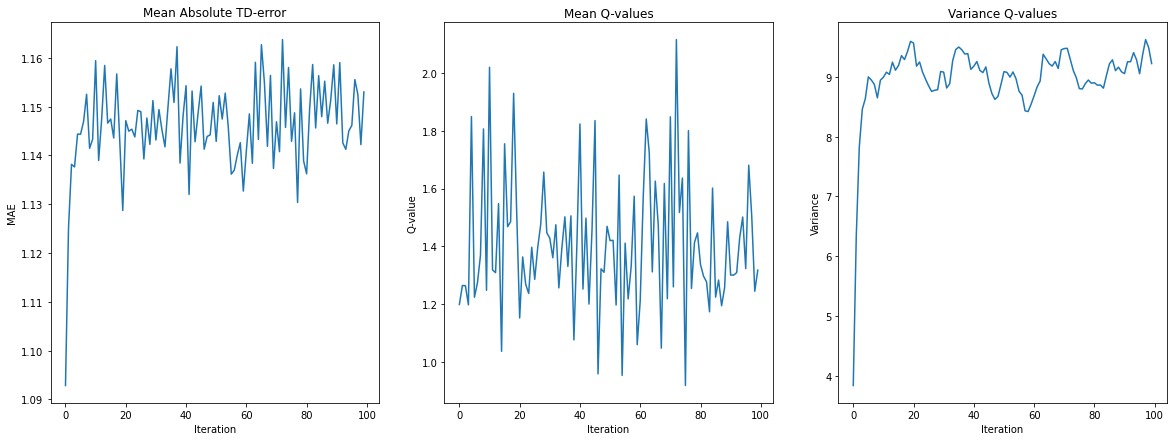

In [31]:
plt.figure(figsize=(20, 7))

plt.subplot(1, 3, 1)
plt.plot(td_errors)
plt.title('Mean Absolute TD-error')
plt.xlabel('Iteration')
plt.ylabel('MAE')

plt.subplot(1, 3, 2)
plt.plot(meanQs)
plt.title('Mean Q-values')
plt.xlabel('Iteration')
plt.ylabel('Q-value')

plt.subplot(1, 3, 3)
plt.plot(varQs)
plt.title('Variance Q-values')
plt.xlabel('Iteration')
plt.ylabel('Variance')

plt.show()

### Deriving V(s)

As $V(s) = max_a(Q(s, a))$ under an optimal policy, we simply take the action associated with the most reward and set $V(s)=Q(s, argmax_a(Q(s, a))$;

In [35]:
# Create Q-table with every (state, action) pair and state id (not next state this time!)
X_prev_repeated = np.repeat(X_prev, num_actions, axis=0)
y_repeated = np.tile(np.eye(num_actions), num_states).T  
repeated_state_ids = np.repeat(np.arange(num_states), num_actions, axis=0)[:, None]

# Create table with states, actions and state_ids (to aggregate on)
Qtable_prev = np.concatenate([X_prev_repeated, y_repeated, repeated_state_ids], axis=1)
Qtable_prev = pd.DataFrame(data=Qtable_prev, columns=input_cols + ['state'])
Qtable_prev

,max_vp,total_iv_fluid,sirs_score,sofa_score,weight,ventilator,height,age,gender,heart_rate,...,16,17,18,19,20,21,22,23,24,state
0,0.0,0.000000,0.5,0.647059,0.239087,0.0,0.0,0.825484,1.0,0.564606,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.5,0.647059,0.239087,0.0,0.0,0.825484,1.0,0.564606,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.5,0.647059,0.239087,0.0,0.0,0.825484,1.0,0.564606,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.5,0.647059,0.239087,0.0,0.0,0.825484,1.0,0.564606,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.5,0.647059,0.239087,0.0,0.0,0.825484,1.0,0.564606,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5095,0.0,0.708464,0.5,0.000000,0.000000,0.0,0.0,0.964097,0.0,0.206033,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,203.0
5096,0.0,0.708464,0.5,0.000000,0.000000,0.0,0.0,0.964097,0.0,0.206033,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,203.0
5097,0.0,0.708464,0.5,0.000000,0.000000,0.0,0.0,0.964097,0.0,0.206033,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,203.0
5098,0.0,0.708464,0.5,0.000000,0.000000,0.0,0.0,0.964097,0.0,0.206033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,203.0


In [36]:
# Predict Q(s, a) for every state s and action a
Qtable_prev['Q'] = rf.predict(Qtable_prev[input_cols].values)

# Compute V(s) as max_a[Q(s, a)]
V = Qtable_prev.groupby('state', sort=False)['Q'].max()
V

state
0.0      0.821852
1.0      0.821852
2.0      0.821852
3.0      0.821852
4.0      0.928279
           ...   
199.0    0.786578
200.0    0.786578
201.0    0.902536
202.0    1.024760
203.0   -7.192122
Name: Q, Length: 204, dtype: float64